### Imports

In [1]:
import os
import time

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

### Set Hyperparameters

In [2]:
random_seed = 1
batch_size = 128
learning_rate = 1e-3 # high learning rate b/c low epochs
num_epochs = 20
num_classes = 10
p_drop = 0.0 # with low epochs, dropout does not help. dropout also causes noisier gradients which require lower learning rates. ~2% worse accuracy with p_drop=0.1 vs 0

num_workers = 12 # number of threads
pin_memory = True

### Select Device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Target device is {device}')
device = torch.device(device)

Target device is cuda


### Load and Preprocess FashionMNIST

In [4]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

train_dataset = datasets.FashionMNIST('./FashionMNIST', train=True, transform=data_transform, download=True)
test_dataset = datasets.FashionMNIST('./FashionMNIST', train=False, transform=data_transform, download=True)
train_dataset, valid_dataset = random_split(train_dataset, lengths=[55000, 5000])


### Mini-batch Data Loaders

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=pin_memory
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory
)

### Visualize Data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 1, 28, 28])


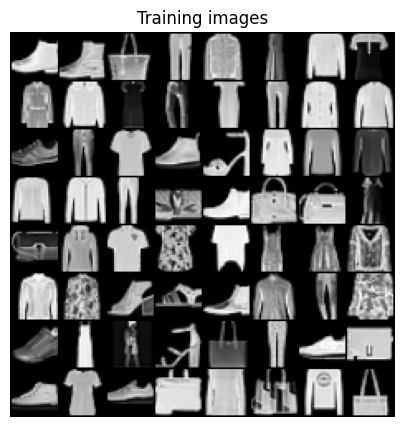

Labels = 
[[9 9 8 1 4 3 4 0]
 [6 4 3 1 3 1 4 2]
 [7 1 6 9 5 4 2 6]
 [4 4 1 8 9 8 8 3]
 [8 2 0 6 0 3 3 6]
 [4 6 5 5 9 6 1 6]
 [7 3 3 5 8 1 7 8]
 [7 0 7 8 6 8 2 8]]


In [6]:
import torchvision.utils as vutils

%matplotlib inline

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))

### Load Data into GPU
Implemented but was not significantly faster than calling `.to` in the training loop

In [7]:
"""
https://pytorch.org/tutorials/beginner/nn_tutorial.html#using-your-gpu
"""

# class WrappedDataLoader:
#     def __init__(self, dl, func):
#         self.dl = dl
#         self.func = func

#     def __len__(self):
#         return len(self.dl)

#     def __iter__(self):
#         for b in self.dl:
#             yield (self.func(*b))

# def preprocess(x, y):
#     return x.view(-1, 1, 28, 28).to(device), y.to(device)

# train_loader = WrappedDataLoader(train_loader, preprocess)
# valid_loader = WrappedDataLoader(valid_loader, preprocess)
# test_loader = WrappedDataLoader(test_loader, preprocess)

'\nhttps://pytorch.org/tutorials/beginner/nn_tutorial.html#using-your-gpu\n'

### CNN

In [8]:
"""
VGG16
- Inspired multiple same convolutions followed by pooling

https://lernapparat.de/pytorch-inplace
- Argues against using inplace operations
https://arxiv.org/pdf/1904.03392.pdf
- Ordering of ReLU, BatchNorm, and Dropout based on figure 3
"""

class CNN(torch.nn.Module):
    def __init__(self, num_classes, p_drop):
        super().__init__()

        self.num_classes = num_classes
        self.cnn_features = torch.nn.Sequential(
            # Conv1
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            # Conv2
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(p=p_drop),

            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.fc_features = torch.nn.Sequential(
            torch.nn.Flatten(),

            torch.nn.Linear(32*7*7, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(p=p_drop),

            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(p=p_drop),

            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(p=p_drop),

            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(p=p_drop),

            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=p_drop),

            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=p_drop),
            
            torch.nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn_features(x)
        x = self.fc_features(x)
        return x

### Accuracy Metric

In [9]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

### Train and Test

In [10]:
"""
https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
- num_workers = # threads
- pin_memory = True for CUDA
- Use parameter.grad = None instead of model.zero_grad() or optimizer.zero_grad()
- Enable cuDNN Tuner
"""

torch.manual_seed(random_seed)
model = CNN(num_classes=num_classes, p_drop=p_drop)
model = model.to(device)

torch.backends.cudnn.benchmark = True

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

cost_history = []

start = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0

    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        #zero out the gradients
        for param in model.parameters():
            param.grad = None
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        epoch_loss += loss.item()

        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")

    epoch_loss /= len(train_loader)
    cost_history.append(epoch_loss)

    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed: {(time.time() - start) / 60:.2f} min")
    print()

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

# Test
model = model.eval()
ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Epoch: 001/020 | Batch: 100/429 | Loss: 0.6235
Epoch: 001/020 | Batch: 200/429 | Loss: 0.5360
Epoch: 001/020 | Batch: 300/429 | Loss: 0.3943
Epoch: 001/020 | Batch: 400/429 | Loss: 0.4965
Epoch: 001 Learning Rate 0.00100000 -> 0.00100000
Train Accuracy: 85.384
Validation Accuracy: 84.840
Time elapsed: 0.23 min

Epoch: 002/020 | Batch: 100/429 | Loss: 0.3958
Epoch: 002/020 | Batch: 200/429 | Loss: 0.5202
Epoch: 002/020 | Batch: 300/429 | Loss: 0.2631
Epoch: 002/020 | Batch: 400/429 | Loss: 0.2651
Epoch: 002 Learning Rate 0.00100000 -> 0.00050000
Train Accuracy: 88.267
Validation Accuracy: 87.400
Time elapsed: 0.44 min

Epoch: 003/020 | Batch: 100/429 | Loss: 0.2080
Epoch: 003/020 | Batch: 200/429 | Loss: 0.2874
Epoch: 003/020 | Batch: 300/429 | Loss: 0.1856
Epoch: 003/020 | Batch: 400/429 | Loss: 0.2581
Epoch: 003 Learning Rate 0.00050000 -> 0.00050000
Train Accuracy: 89.722
Validation Accuracy: 88.760
Time elapsed: 0.66 min

Epoch: 004/020 | Batch: 100/429 | Loss: 0.3268
Epoch: 004/020

### Plot Loss

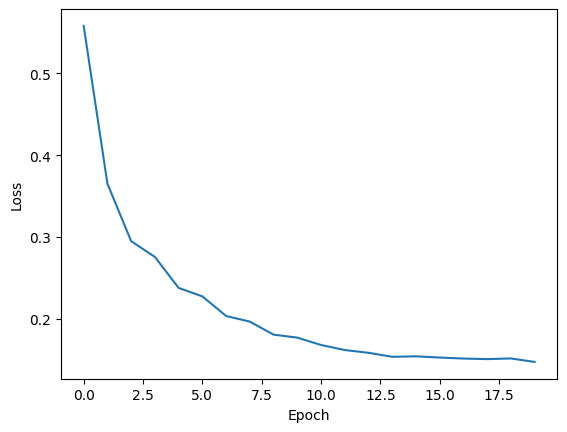

In [11]:
plt.plot(cost_history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Plot Confusion Matrix for Test Data

In [16]:
# refresh test_loader with centercrop rather than randomcrop
data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

test_dataset = datasets.FashionMNIST('./FashionMNIST', train=False, transform=data_transform, download=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory
)

# https://stackoverflow.com/a/53291323/8930299
confusion_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        pred_labels = torch.argmax(outputs, axis=1)

        for i in range(labels.shape[0]):
                confusion_matrix[labels[i], pred_labels[i]] += 1


confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

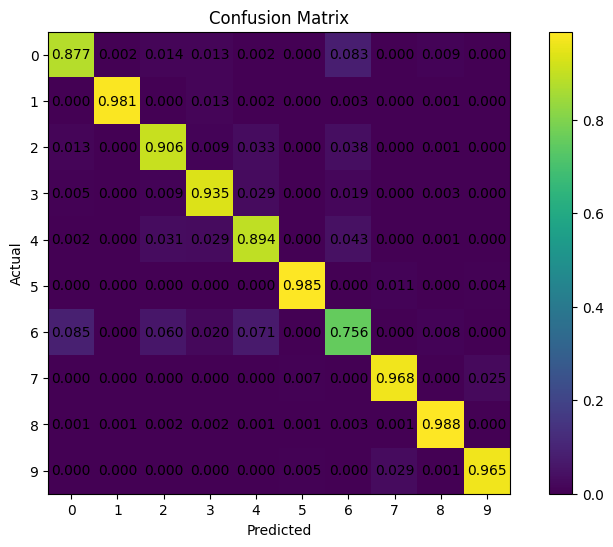

In [17]:
fig, ax = plt.subplots()

ax.set_title('Confusion Matrix')
fig.set_size_inches(10, 6)

cax = ax.matshow(confusion_matrix)

# If a log scale is desired, use below instead of above:
# https://stackoverflow.com/a/14650400/8930299
# import copy
# my_cmap = copy.copy(matplotlib.colormaps['grey']) # copy the default cmap
# my_cmap.set_bad((0,0,0))
# cax = ax.matshow(confusion_matrix, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap=my_cmap)

cbar = fig.colorbar(cax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.xaxis.set_ticks_position('bottom')

# https://stackoverflow.com/a/20998634/8930299
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

plt.show()